# Import Libraries

In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tarfile
from PIL import Image
import os
from pathlib import Path
import os, urllib
import urllib.request
import numpy as np
import pandas as pd

# Get the Flikr Data and Unzip it

In [2]:
%%capture
!wget -nc <url from flickr>
!unzip -n ./FlickrLogos-32_dataset_v2.zip 

# Home Directory for the Data

In [3]:
data_directory = "./FlickrLogos-v2/"

# Load the files containing the filenames for Train, Validation and Test

In [4]:
train_list_filename = data_directory+"trainset.relpaths.txt"
val_list_filename = data_directory+"valset.relpaths.txt"
test_list_filename = data_directory+"testset.relpaths.txt"

# Segregate the filenames for Train, Validation and Test

In [5]:
with open(train_list_filename) as f:
    train_filenames = f.read().splitlines()
    
with open(val_list_filename) as f:
    val_filenames = f.read().splitlines()
    
with open(test_list_filename) as f:
    test_filenames = f.read().splitlines()
    
    
print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

320
3960
3960


# Function defined for getting the masked Image (no masking is done now)

In [6]:
def create_masked_images(base_directory,filenames,dest_folder_name):
    for filename in filenames:
        image_filepath = base_directory+filename
        image = mx.image.imdecode(open(image_filepath, 'rb').read())
        mask_filepath = base_directory+filename.replace('/jpg/','/masks/')+'.mask.merged.png'
        if False:#os.path.exists(mask_filepath):
            mask = mx.image.imdecode(open(mask_filepath, 'rb').read())
            masked_image = image * (mask>100)
        else:
            masked_image = image 
        dest_path = image_filepath.replace('classes/jpg',dest_folder_name).replace('no-logo','z-no-logo')
        directory_path = Path(os.path.dirname(dest_path))
        directory_path.mkdir(parents=True,exist_ok=True)
        im = Image.fromarray(masked_image.asnumpy())
        im.save(dest_path)

# Separate folders are created for Train Validation and Test and corresponding data after masking the images are stored

In [7]:
create_masked_images(base_directory=data_directory,filenames=train_filenames,dest_folder_name='train_data')
create_masked_images(base_directory=data_directory,filenames=val_filenames,dest_folder_name='val_data')
create_masked_images(base_directory=data_directory,filenames=test_filenames,dest_folder_name='test_data')

# Lets see the $Location$ where the mxnet source code is stored by pip3

In [8]:
!pip3 show mxnet-cu80
#!pip3 show mxnet

Name: mxnet-cu80
Version: 0.11.0
Summary: MXNet is an ultra-scalable deep learning framework. This version uses CUDA-8.0.
Home-page: https://github.com/dmlc/mxnet
Author: UNKNOWN
Author-email: UNKNOWN
License: Apache 2.0
Location: /usr/local/lib/python3.5/dist-packages
Requires: numpy, graphviz


# Define $MXNET\_HOME = Location + "/mxnet"$

In [9]:
import os
MXNET_HOME = "/usr/local/lib/python3.5/dist-packages/mxnet"
#MXNET_HOME = "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mxnet"

# Using $MXNET\_HOME/tools/im2rec.py$ Convert Train, Validation and Test Folders containing images into $.rec$ files

In [10]:

os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/train ./FlickrLogos-v2/train_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/train ./FlickrLogos-v2/train_data'%MXNET_HOME)

os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/val ./FlickrLogos-v2/val_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/val ./FlickrLogos-v2/val_data'%MXNET_HOME)

os.system('python3 %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 ./FlickrLogos-v2/test ./FlickrLogos-v2/test_data'%MXNET_HOME)
os.system('python3 %s/tools/im2rec.py --num-thread 16 ./FlickrLogos-v2/test ./FlickrLogos-v2/test_data'%MXNET_HOME)


0

# Lets Generate the Label Indexer Mapping from the generated $train.lst$

In [11]:
df = pd.read_csv("./FlickrLogos-v2/train.lst",sep='\t',names=['_1','index','path'])
df['label'] = df.apply(lambda row: row['path'].split('/')[0],axis=1)
unique_df = df[['index','label']].drop_duplicates()
unique_df['index'] = unique_df['index'].astype(np.int8)
unique_df.set_index('index',inplace=True)
label_indexer_dict = unique_df.to_dict()['label']
print(label_indexer_dict)

{0: 'HP', 1: 'adidas', 2: 'aldi', 3: 'apple', 4: 'becks', 5: 'bmw', 6: 'carlsberg', 7: 'chimay', 8: 'cocacola', 9: 'corona', 10: 'dhl', 11: 'erdinger', 12: 'esso', 13: 'fedex', 14: 'ferrari', 15: 'ford', 16: 'fosters', 17: 'google', 18: 'guiness', 19: 'heineken', 20: 'milka', 21: 'nvidia', 22: 'paulaner', 23: 'pepsi', 24: 'rittersport', 25: 'shell', 26: 'singha', 27: 'starbucks', 28: 'stellaartois', 29: 'texaco', 30: 'tsingtao', 31: 'ups'}


# Lets define some utility functions

### Lets define the function for mapping the indices back to actual labels

In [12]:
def index_to_label(a):
        return [label_indexer_dict[label_index] if label_index!=32 else 'no-logo' for label_index in a]
def get_predicted_label(predicted_label_index):
    predicted_label = np.ma.apply_along_axis(index_to_label, 1, predicted_label_index)
    return predicted_label

### Lets define a function to get the top n prediction with $threshold = 0.5$

In [13]:
def get_top_n_label_index_prediction(prob,n,threshold=0.5):
    prob_nparray = prob.asnumpy()
    x = prob_nparray<threshold
    prob_nparray[x] = 0

    def get_top_n_label_index(a,n):
        array = np.argsort(a)[a.shape[0]-n:]
        non_zero_count = np.count_nonzero(a)
        if non_zero_count > n:
            zero_count = 0
        else:
            zero_count = n - non_zero_count        
        for i in range(zero_count):
            array[i] = 32
        return array

    top_n_prediction = np.apply_along_axis(get_top_n_label_index, 1, prob_nparray,n)
    return top_n_prediction

### Lets define accuracy calculation 

In [14]:
def calculate_accuracy(actual_label,predicted_label):
    ll = np.column_stack((actual_label,predicted_label))
    def is_present(a):
        if a[0] in a[1:]:
            return 1
        else:
            return 0
    zz = np.apply_along_axis(is_present, 1, ll)
    return zz.mean()

# Function for getting ImageRecordIter for Train Validation and Test Data

In [15]:
def get_iterators(batch_size, data_shape):
    train = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/train.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/val.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    test = mx.io.ImageRecordIter(
        path_imgrec         = './FlickrLogos-v2/test.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val,test)

# Define the constants

In [21]:
batch_size= 30
num_classes = 32
num_gpu = 1
batch_per_gpu = 30
num_epochs = 8

# Load the data for Train Validation and Test

In [17]:
(train_iter, val_iter,test_iter) = get_iterators(batch_size=batch_size,data_shape=(3,64,64))

# Lets keep the ground truth for the Test Data handy for future calculations

In [18]:
result_array = np.array([])
for i in range(132):
    result_array = np.append(result_array, test_iter.next().label[0].asnumpy())
test_label = np.apply_along_axis(index_to_label, -1, result_array)
print(test_label)
print(len(test_label))
test_iter.reset()

['shell' 'shell' 'no-logo' ..., 'no-logo' 'no-logo' 'heineken']
3960


# Define the MLP Model

In [19]:
data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

fc3  = mx.sym.FullyConnected(data=act2, num_hidden=num_classes)

mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# Visualize the MLP Model

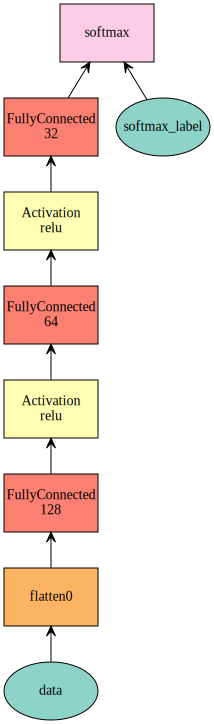

In [20]:
mx.viz.plot_network(symbol=mlp)

# Train the MLP Model

In [22]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

mlp_model = mx.mod.Module(symbol=mlp, context=[mx.gpu(i) for i in range(num_gpu)])
mlp_model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.01,'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              num_epoch=num_epochs)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Train-accuracy=0.027273
INFO:root:Epoch[0] Time cost=0.045
INFO:root:Epoch[0] Validation-accuracy=0.007576
INFO:root:Epoch[1] Train-accuracy=0.042424
INFO:root:Epoch[1] Time cost=2.745
INFO:root:Epoch[1] Validation-accuracy=0.008838
INFO:root:Epoch[2] Train-accuracy=0.043333
INFO:root:Epoch[2] Time cost=1.639
INFO:root:Epoch[2] Validation-accuracy=0.007828
INFO:root:Epoch[3] Train-accuracy=0.024242
INFO:root:Epoch[3] Time cost=3.835
INFO:root:Epoch[3] Validation-accuracy=0.007071
INFO:root:Epoch[4] Train-accuracy=0.021212
INFO:root:Epoch[4] Time cost=2.732
INFO:root:Epoch[4] Validation-accuracy=0.006818
INFO:root:Epoch[5] Train-accuracy=0.030000
INFO:root:Epoch[5] Time cost=1.639
INFO:root:Epoch[5] Validation-accuracy=0.007323
INFO:root:Epoch[6] Train-accuracy=0.033333
INFO:root:Epoch[6] Time cost=3.837
INFO:root:Epoch[6] Validation-accuracy=0.007323
INFO:root:Epoch[7] Train-accuracy=0.021212
INFO:root:Epoch[7] Time cost=2.737
INFO:root:Epoch[7] Validation-accuracy=0

# Test Accuracy of the MLP Model for top 3 predictions

### Lets take the mean of the probbilities as the threshold values to choose top 3 labels

In [23]:
prob = mlp_model.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob,3,threshold=prob.asnumpy().mean())
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.022222222222222223

In [24]:
mlp_model.save_checkpoint("mlp-model",0)

INFO:root:Saved checkpoint to "mlp-model-0000.params"


# Reset the Data Iterators for Train Validation and Test

In [25]:
train_iter.reset()
val_iter.reset()
test_iter.reset()

# Define the CNN Model

In [26]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))

flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="relu")

fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=num_classes)

cnn = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

# Lets Visualize the CNN Model

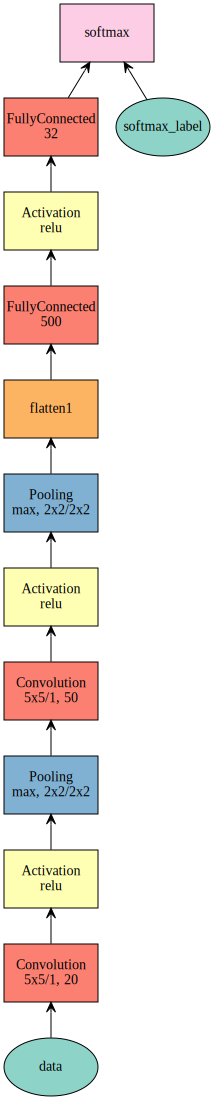

In [27]:
mx.viz.plot_network(symbol=cnn)

# Train the CNN Model

In [28]:
# create a trainable module on GPU 0
cnn_model = mx.mod.Module(symbol=cnn, context=[mx.gpu(i) for i in range(num_gpu)])
# train with the same
cnn_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01,'momentum':0.9},
                eval_metric='acc',
                num_epoch=num_epochs)

INFO:root:Epoch[0] Batch [10]	Speed: 81.41 samples/sec	accuracy=0.018182
INFO:root:Epoch[0] Train-accuracy=nan
INFO:root:Epoch[0] Time cost=4.950
INFO:root:Epoch[0] Validation-accuracy=0.007576
INFO:root:Epoch[1] Batch [10]	Speed: 108.41 samples/sec	accuracy=0.030303
INFO:root:Epoch[1] Train-accuracy=nan
INFO:root:Epoch[1] Time cost=2.775
INFO:root:Epoch[1] Validation-accuracy=0.008586
INFO:root:Epoch[2] Train-accuracy=0.030000
INFO:root:Epoch[2] Time cost=1.665
INFO:root:Epoch[2] Validation-accuracy=0.007576
INFO:root:Epoch[3] Batch [10]	Speed: 109.20 samples/sec	accuracy=0.021212
INFO:root:Epoch[3] Train-accuracy=nan
INFO:root:Epoch[3] Time cost=3.862
INFO:root:Epoch[3] Validation-accuracy=0.007576
INFO:root:Epoch[4] Batch [10]	Speed: 108.62 samples/sec	accuracy=0.021212
INFO:root:Epoch[4] Train-accuracy=nan
INFO:root:Epoch[4] Time cost=2.775
INFO:root:Epoch[4] Validation-accuracy=0.007323
INFO:root:Epoch[5] Train-accuracy=0.020000
INFO:root:Epoch[5] Time cost=1.674
INFO:root:Epoch[5

# Test Accuracy of CNN

In [29]:
prob = cnn_model.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob,3,threshold=prob.asnumpy().mean())
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.022727272727272728

# Lets save the CNN Model

In [37]:
cnn_model.save_checkpoint("cnn-model",0)

INFO:root:Saved checkpoint to "cnn-model-0000.params"


# Function for downloading a Pretrained Model 

In [38]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

# Function for fine tuning the Pretrained model based on the number of classes for a specific use case

In [39]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

# Function for fitting the fine tuned Model

In [40]:
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

def fit(symbol, arg_params, aux_params, train, val, num_gpus,num_epochs):
    devs = [mx.gpu(i) for i in range(num_gpus)]
    mod = mx.mod.Module(symbol=symbol, context=devs)
    mod.fit(train, val,
        num_epoch=num_epochs,
        arg_params=arg_params,
        aux_params=aux_params,
        allow_missing=True,
        kvstore='device',
        optimizer='sgd',
        optimizer_params={'learning_rate':0.01,'momentum':0.9},
        initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2),
        eval_metric='acc')
    metric = mx.metric.Accuracy()
    return mod,mod.score(val, metric)

# Fit the Pretrained Model

In [43]:
train_iter.reset()
val_iter.reset()
test_iter.reset()

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes)

mod_resnet,mod_score = fit(new_sym, new_args, aux_params, train_iter, val_iter, num_gpu,num_epochs=num_epochs)


INFO:root:Epoch[0] Train-accuracy=0.030303
INFO:root:Epoch[0] Time cost=3.024
INFO:root:Epoch[0] Validation-accuracy=0.008081
INFO:root:Epoch[1] Train-accuracy=0.042424
INFO:root:Epoch[1] Time cost=3.006
INFO:root:Epoch[1] Validation-accuracy=0.007071
INFO:root:Epoch[2] Train-accuracy=0.026667
INFO:root:Epoch[2] Time cost=2.031
INFO:root:Epoch[2] Validation-accuracy=0.009091
INFO:root:Epoch[3] Train-accuracy=0.024242
INFO:root:Epoch[3] Time cost=4.076
INFO:root:Epoch[3] Validation-accuracy=0.012374
INFO:root:Epoch[4] Train-accuracy=0.057576
INFO:root:Epoch[4] Time cost=2.855
INFO:root:Epoch[4] Validation-accuracy=0.014899
INFO:root:Epoch[5] Train-accuracy=0.063333
INFO:root:Epoch[5] Time cost=2.060
INFO:root:Epoch[5] Validation-accuracy=0.017929
INFO:root:Epoch[6] Train-accuracy=0.072727
INFO:root:Epoch[6] Time cost=4.039
INFO:root:Epoch[6] Validation-accuracy=0.016162
INFO:root:Epoch[7] Train-accuracy=0.118182
INFO:root:Epoch[7] Time cost=2.972
INFO:root:Epoch[7] Validation-accuracy=0

# Test Accuracy of the Pretrained Model

### Top 3 label prediction

In [45]:
prob = mod_resnet.predict(test_iter)
top_3_prediction = get_top_n_label_index_prediction(prob,3,threshold=0.5)
predicted_label = get_predicted_label(top_3_prediction)
calculate_accuracy(test_label,predicted_label)

0.75757575757575757

# Lets save the Model

In [46]:
mod_resnet.save_checkpoint("resnet-model",0)

INFO:root:Saved checkpoint to "resnet-model-0000.params"


# Lets define functions to predict an online image and load already trained model for prediction

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (64, 64))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url,mod):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], index_to_label([a[i]])))
        
def load_model(pathname):
    sym, arg_params, aux_params = mx.model.load_checkpoint(pathname, 0)
    mod = mx.mod.Module(symbol=sym, context=mx.gpu(), label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,64,64))], 
             label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    return mod

# Lets load the stored Models

In [48]:
mod_mlp = load_model('mlp-model')
mod_cnn = load_model('cnn-model')
mod_res = load_model('resnet-model')

# Lets apply different models and see the output

INFO:root:ford-logo.jpg exists, skipping download


probability=0.031782, class=['ford']
probability=0.031771, class=['heineken']
probability=0.031750, class=['nvidia']
probability=0.031723, class=['milka']
probability=0.031711, class=['ups']


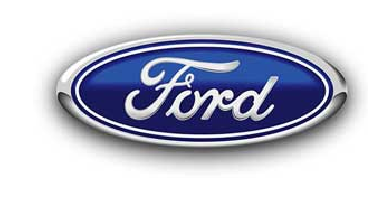

In [54]:
predict('https://8096-presscdn-0-43-pagely.netdna-ssl.com/wp-content/uploads/2014/10/ford-logo.jpg',mod_mlp)

INFO:root:ford-logo.jpg exists, skipping download


probability=0.031452, class=['HP']
probability=0.031389, class=['cocacola']
probability=0.031380, class=['corona']
probability=0.031376, class=['google']
probability=0.031362, class=['nvidia']


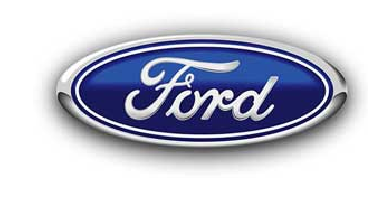

In [53]:
predict('https://8096-presscdn-0-43-pagely.netdna-ssl.com/wp-content/uploads/2014/10/ford-logo.jpg',mod_cnn)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): 8096-presscdn-0-43-pagely.netdna-ssl.com
DEBUG:urllib3.connectionpool:https://8096-presscdn-0-43-pagely.netdna-ssl.com:443 "GET /wp-content/uploads/2014/10/ford-logo.jpg HTTP/1.1" 200 7992
INFO:root:downloaded https://8096-presscdn-0-43-pagely.netdna-ssl.com/wp-content/uploads/2014/10/ford-logo.jpg into ford-logo.jpg successfully


probability=0.231588, class=['ford']
probability=0.140405, class=['guiness']
probability=0.082720, class=['texaco']
probability=0.070502, class=['esso']
probability=0.069073, class=['stellaartois']


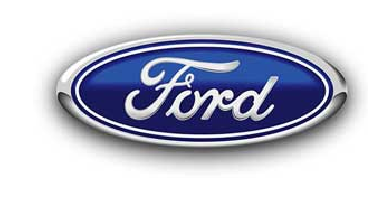

In [52]:
predict('https://8096-presscdn-0-43-pagely.netdna-ssl.com/wp-content/uploads/2014/10/ford-logo.jpg',mod_res)